# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats
import sklearn.preprocessing as pre
from datetime import datetime
from decimal import Decimal

import pymrmr

## Part 1 - Importing Datasets

### Functions for Data Import

In [2]:
# Find .csv files
raw_datasets = {}
dataset_paths = glob.glob('imu_data/*.csv')
N_DATASETS = len(dataset_paths)

dataset_paths

['imu_data/PhoneLeftConcrete.csv',
 'imu_data/PhoneLeftCarpet.csv',
 'imu_data/WheelRightGravel.csv',
 'imu_data/PhoneLeftSidewalk.csv',
 'imu_data/WheelLeftConcrete.csv',
 'imu_data/PhoneMiddleSidewalk.csv',
 'imu_data/WheelLeftCarpet.csv',
 'imu_data/WheelRightCarpet.csv',
 'imu_data/WheelLeftGravel.csv',
 'imu_data/PhoneMiddleConcrete.csv',
 'imu_data/WheelLeftLinoleum.csv',
 'imu_data/PhoneRightGrass.csv',
 'imu_data/WheelRightConcrete.csv',
 'imu_data/PhoneRightGravel.csv',
 'imu_data/PhoneMiddleCarpet.csv',
 'imu_data/PhoneRightSidewalk.csv',
 'imu_data/WheelRightGrass.csv',
 'imu_data/PhoneRightCarpet.csv',
 'imu_data/FrameMiddleGravel.csv',
 'imu_data/WheelRightLinoleum.csv',
 'imu_data/FrameMiddleGrass.csv',
 'imu_data/PhoneMiddleLinoleum.csv',
 'imu_data/WheelLeftGrass.csv',
 'imu_data/FrameMiddleCarpet.csv',
 'imu_data/FrameMiddleLinoleum.csv',
 'imu_data/PhoneLeftLinoleum.csv',
 'imu_data/PhoneLeftGravel.csv',
 'imu_data/FrameMiddleSidewalk.csv',
 'imu_data/WheelLeftSidewal

In [3]:
'''Set indices of a dataframe depending on given label'''
def set_indices(dataframe):
    if 'Frequency' in dataframe.columns:
        return dataframe.set_index('Frequency')
    elif 'Epoch Time' in dataframe.columns:
        return dataframe.set_index('Epoch Time')
    else:
        raise('Unknown dataframe columns')

In [175]:
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']

'''Get the terrain of given label (e.g. WheelLeftConcrete) as an integer'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

def get_terrain_name(terrain_num):
    return terrains[terrain_num]

In [5]:
frame_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Epoch Time']

wheel_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']

phone_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']

data_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']

'''Get columns for given label'''
def get_columns(_label):
    columns = []
    
    # Columns differ depending on device used
    if 'Phone' in _label:
        columns = phone_columns.copy()
    elif 'Frame' in _label:
        columns = frame_columns.copy()
    elif 'Wheel' in _label:
        columns = wheel_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # Transformed datasets replace time columns with frequency
    if ('FFT' in _label or 'PSD' in _label):
        columns.remove('Epoch Time')
        
        if 'Wheel' in _label or 'Phone' in _label:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [6]:
def append_all_columns(columns, append_label):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_label)
    
    return new_columns

### Part (b) - Parsing Data into Pandas

In [7]:
# Import datasets as an array of Pandas DataFrames
TRIM_LEN = 2000 # Number of data points to trim from each side
N_DATA_COL = 6 # Number of columns containing directional data

# Columns not needed right now
remove_columns = ['LINEAR ACCELERATION X (m/s²)', 'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
                  'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)', 'GRAVITY Z (m/s²)', 
                  'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)',
                  'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'ORIENTATION Z (azimuth °)']

dataset_labels = []

for dataset_path in dataset_paths:
    # Parse labels from filenames
    dataset_label = dataset_path.split(' ')[-1].split('/')[-1].split('.')[0]
    dataset_labels.append(dataset_label)
    
    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)
        
    # Drop unused columns
    for to_remove in remove_columns:
        if to_remove in dataset.columns:
            dataset = dataset.drop(to_remove, axis=1)
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)
    
    # Trim edges to account for startup time
    ## Not necessary if we can remove gravity when IMUs are stationary
    ## i.e. Make stationary IMU have zero contribution to FFT
    #dataset = dataset[TRIM_LEN:-TRIM_LEN]
    
    raw_datasets.update({dataset_label: dataset})

In [8]:
# Check dataset validity for Frame data
raw_datasets['FrameMiddleCarpet'].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Epoch Time
0,-0.480044,-2.051458,-9.479465,0.119472,-0.059936,0.060868,1.559244e+09
1,0.573187,-2.526725,-10.752418,0.013585,0.065397,0.119072,1.559244e+09
2,-1.511780,-2.342828,-9.534395,-0.008791,0.018913,0.095364,1.559244e+09
3,-0.074037,-1.287209,-9.586938,0.028769,-0.056073,0.105753,1.559244e+09
4,0.439443,-1.805465,-10.301033,0.104155,0.060469,0.136787,1.559244e+09


In [9]:
# Check dataset validity for Wheel data
raw_datasets['WheelLeftConcrete'].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
28177,4.899659,7.986935,-0.262161,0.040770,-0.030240,-0.006537,141532.071114,1.559244e+09
28178,4.900856,8.008482,-0.228643,0.041169,-0.030640,-0.006138,141532.071114,1.559244e+09
28179,4.958316,7.986935,-0.245402,0.041036,-0.030640,-0.004806,141547.694921,1.559244e+09
28180,4.939162,7.970175,-0.234628,0.040903,-0.030507,-0.004673,141547.694921,1.559244e+09
28181,4.931980,7.961796,-0.221460,0.041036,-0.030906,-0.004806,141610.185385,1.559244e+09


It looks like the update rate of the IMU is non deterministic and lower than the rate the phone samples it at, i.e. the phone receives a non-deterministic number of sequential identical measurements from the IMU when polling at approx 200 Hz.

### Part (b) - Visualizing Time Domain Data

In [10]:
'''Compare time domain data from phones mounted in different locations'''
def phone_compare(dirn, surface):
    plt.clf()
    fig = plt.figure(figsize=(30, 10))
    
    # Use epoch times to align data
    for mount in ('Left', 'Right', 'Middle'):
        plt.plot(raw_datasets['Phone' + mount + surface]['Epoch Time'],
                 raw_datasets['Phone' + mount + surface][dirn], label=mount)
    
    plt.xlabel('Epoch Time (s)')
    plt.ylabel(dirn + ' on ' + surface)
    plt.legend()
    plt.show()

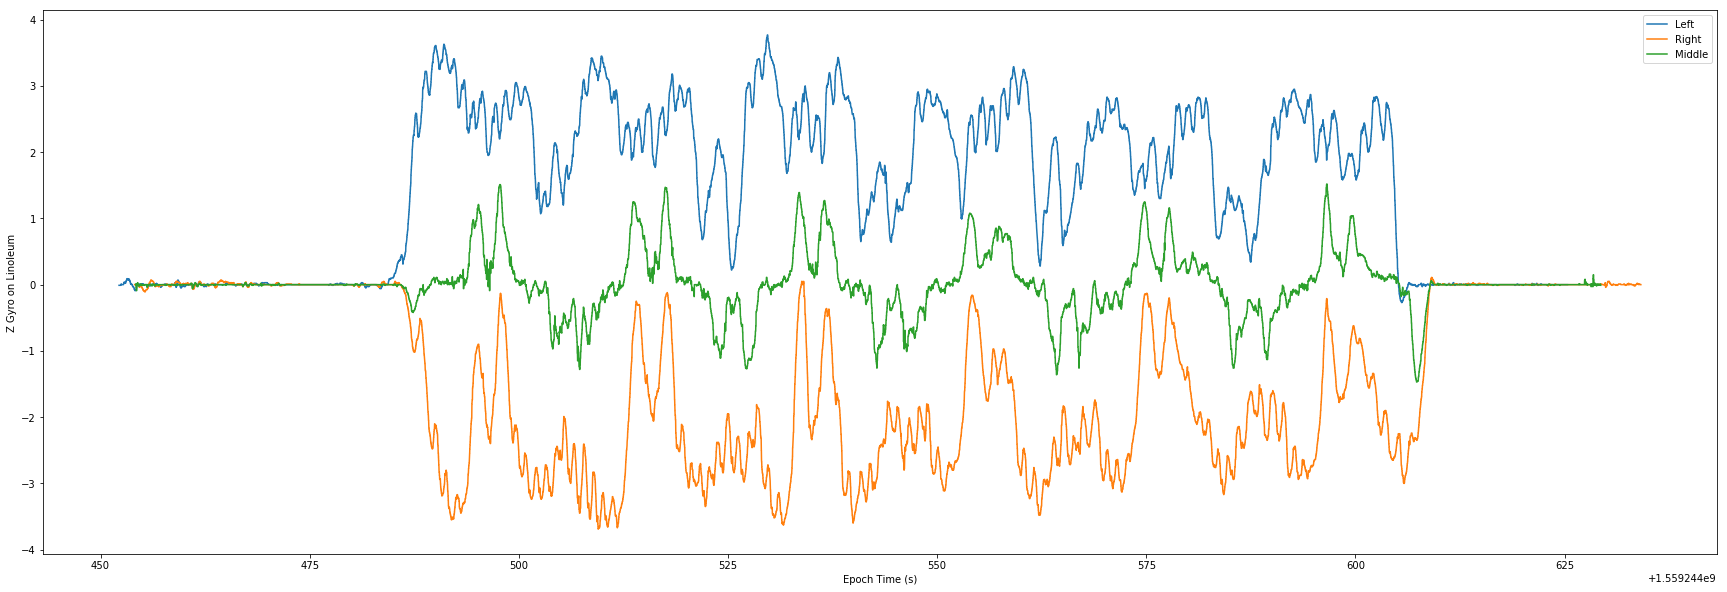

In [11]:
# Compare some phone data (some phone datasets are missing!)
phone_compare('Z Gyro', 'Linoleum')

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(30,10))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel(dirn)
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += label1 + ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

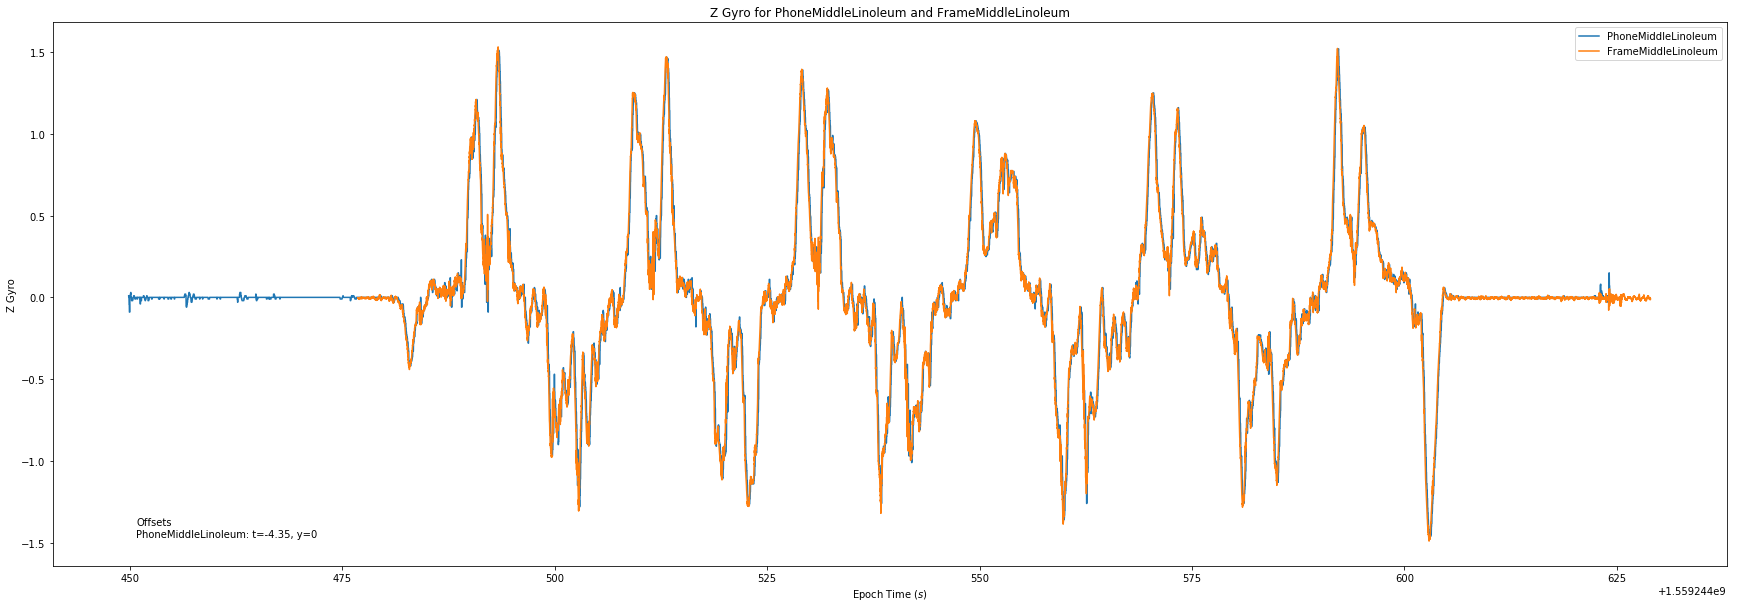

In [13]:
# Compare time-corrected phone and frame data on Linoleum
dataset_compare(raw_datasets, 'PhoneMiddleLinoleum',
                raw_datasets, 'FrameMiddleLinoleum', 'Z Gyro', t_offset=-4.35)

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis)
        axes[i].set_ylabel(y_axis)
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

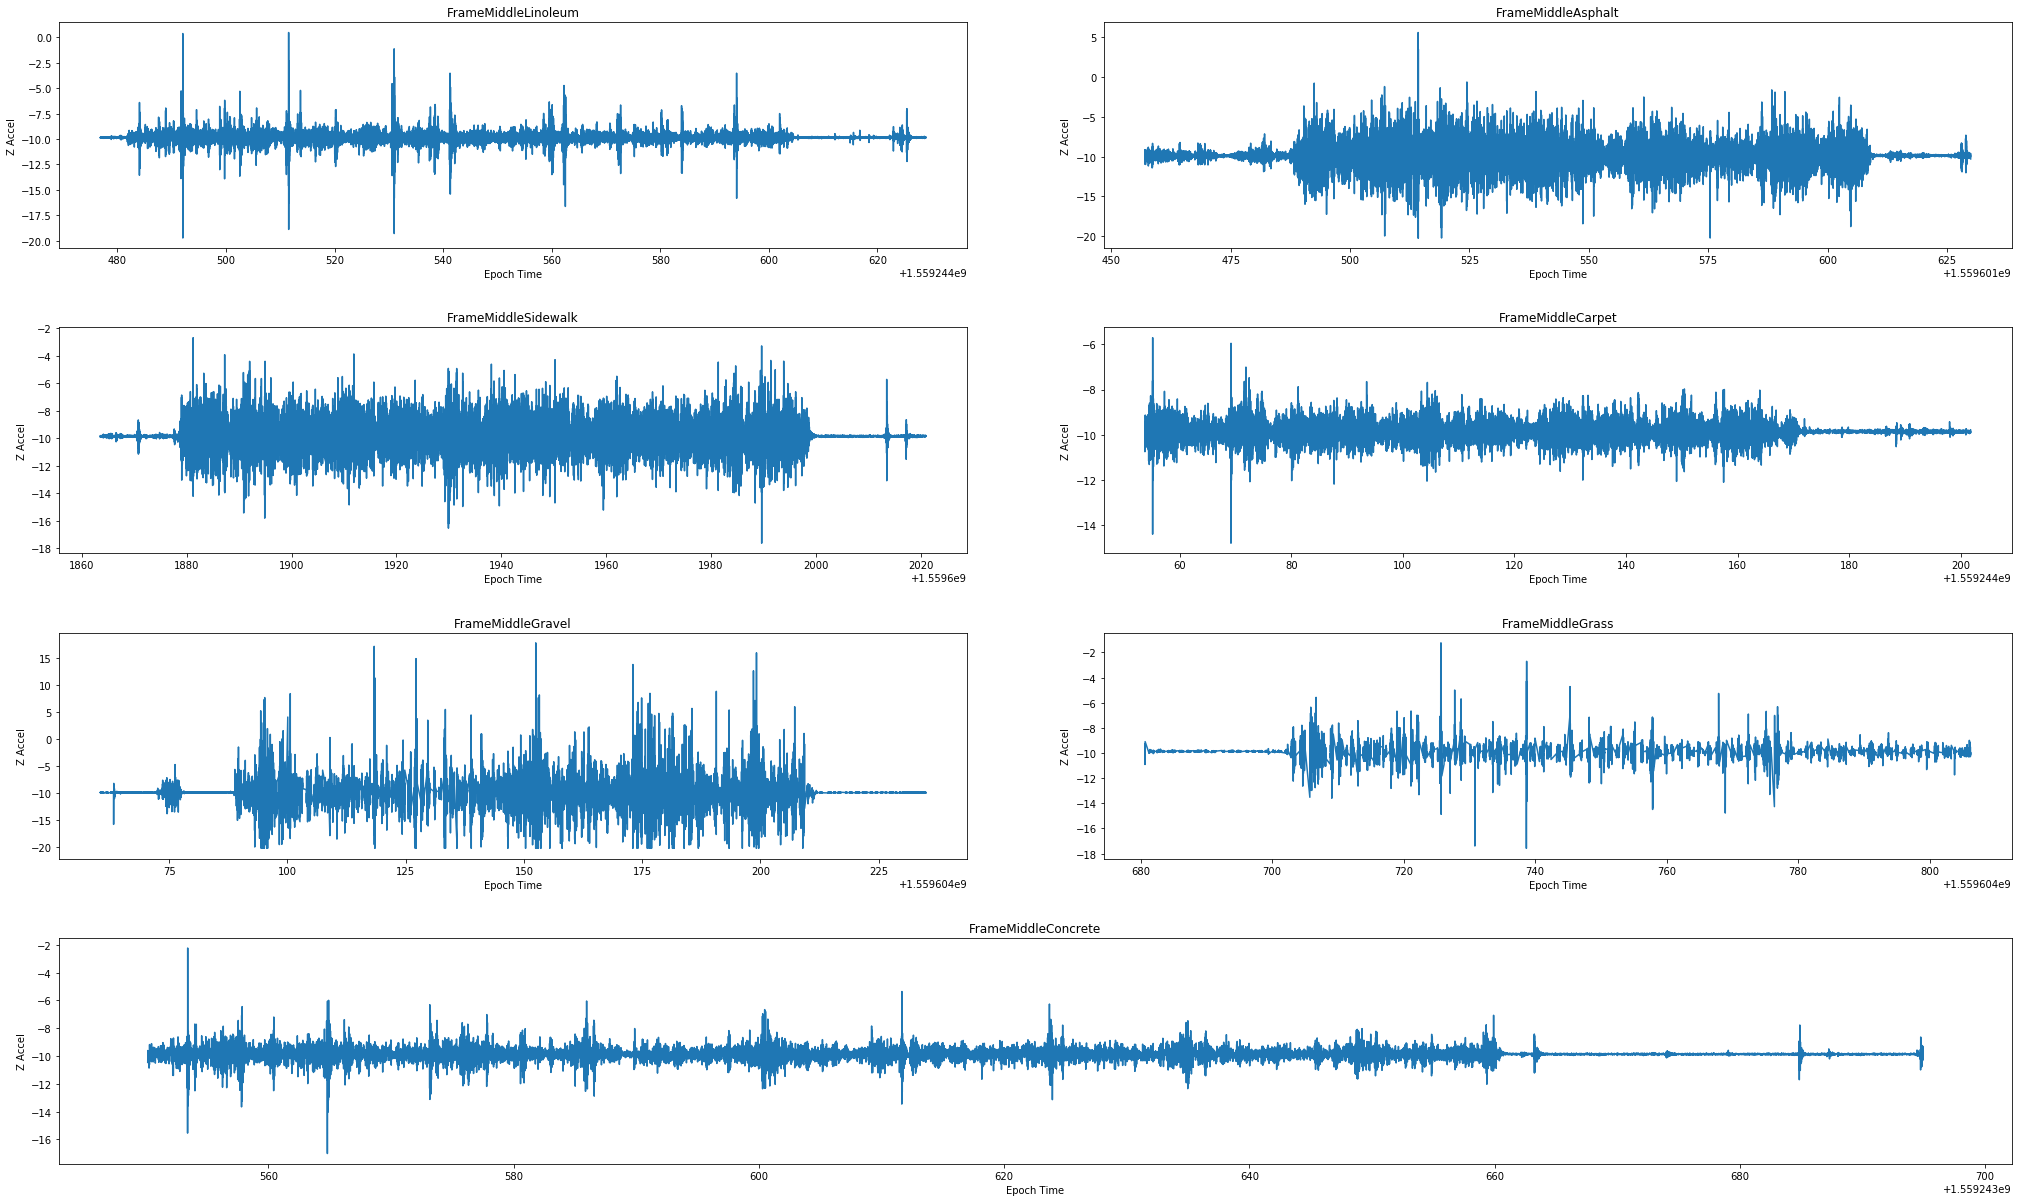

In [15]:
# Plot all Z Accel Frame data vs Epoch Time
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Frame' in label}
plot_all(datasets_to_plot, x_axis='Epoch Time', y_axis='Z Accel')

### Part (c) - Removing Gravity Component

In [16]:
# Remove gravitational acceleration from Frame and Middle Phone data
## Can't remove from wheel-mounted devices because they rotate over time
for label, dataset in raw_datasets.items():
    if ('Middle' in label):
        # Calculate gravity from last 2000 datapoints and subtract from Z Zccel
        ## We need to calculate it manually because device may not be exactly aligned with gravity
        gravity = dataset.loc[-2000:]['Z Accel'].mean()
        print(label + ' Gravity = {}'.format(gravity))
        
        raw_datasets[label]['Z Accel'] = raw_datasets[label]['Z Accel'].apply(lambda x: x - gravity)

FrameMiddleSidewalk Gravity = -9.835418007140523
FrameMiddleLinoleum Gravity = -9.86264645324073
FrameMiddleGravel Gravity = -9.909631963015473
PhoneMiddleSidewalk Gravity = -8.40937495341965
FrameMiddleGrass Gravity = -9.90545407286534
PhoneMiddleConcrete Gravity = -9.71581998213948
FrameMiddleCarpet Gravity = -9.857651011090736
FrameMiddleAsphalt Gravity = -9.887782506616723
PhoneMiddleLinoleum Gravity = -9.70972136576467
FrameMiddleConcrete Gravity = -9.86601232146927
PhoneMiddleCarpet Gravity = -9.722625705573266


### Part (d) - Converting Between Pandas and Numpy

In [17]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.as_matrix()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [18]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [19]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 38
Shape of first dataset: (31481, 8)


Structure of data:

`Terrain Dataset Dictionary -> NP Array with Row = Datapoint, Col = Direction | Time`

## Part 2 - Filtering

Datasheets of smartphone level IMUs suggest that IMU filters data before sending it to the phone, and that the cutoff frequency of this filtering is configurable and changes with update frequency.

Based on the IMU update rate of about 20 ms, this cutoff frequency is already close to 40 Hz, so filtering is probably unnecessary. Its hard to be sure about actual values because this is configured by the phone manufacturer.

In [21]:
'''Get frequencies for given label'''
def get_frequencies(label):
    # Sampling frequency varies for different devices
    if ('Frame' in label):
        f_samp = 100 # Sampling frequency
        f_low = 20 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    else:
        f_samp = 200 # Sampling frequency
        f_low = 40 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
        
    return f_samp, f_low, f_high

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

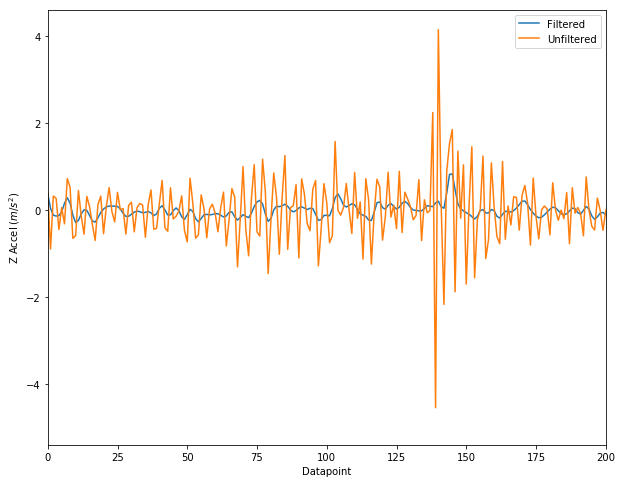

In [22]:
# Make a copy of the dictionary first
datasets = {}

for label, dataset in raw_datasets.items():
    datasets.update({label: np.copy(dataset)})

# Filter each row of each column
for label, dataset in datasets.items():
    
    f_samp, f_low, f_high = get_frequencies(label)
    
    w_low = f_low / (f_samp / 2) # Normalized frequency
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, dataset[:, i])

# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 8))
plt.plot(datasets['FrameMiddleCarpet'][:, 2], label='Filtered')
plt.plot(raw_datasets['FrameMiddleCarpet'][:, 2], label='Unfiltered')
plt.xlim(0, 200)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('Z Accel ($m/s^2$)')
plt.show()

In [23]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 38
Shape of first filtered dataset: (31481, 8)


In [24]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-3.379994,-9.330004,0.129989,2.312777e-46,-2.747322e-09,-0.01,4.0,1.559244e+09
1,-3.383402,-9.327758,0.128580,-9.629829e-47,3.604744e-08,-0.01,9.0,1.559244e+09
2,-3.381776,-9.328919,0.128219,-5.895288e-46,4.091802e-08,-0.01,15.0,1.559244e+09
3,-3.372161,-9.335319,0.131572,-3.663293e-46,-3.754176e-08,-0.01,20.0,1.559244e+09
4,-3.357071,-9.345136,0.139512,9.082450e-46,-1.242242e-07,-0.01,24.0,1.559244e+09


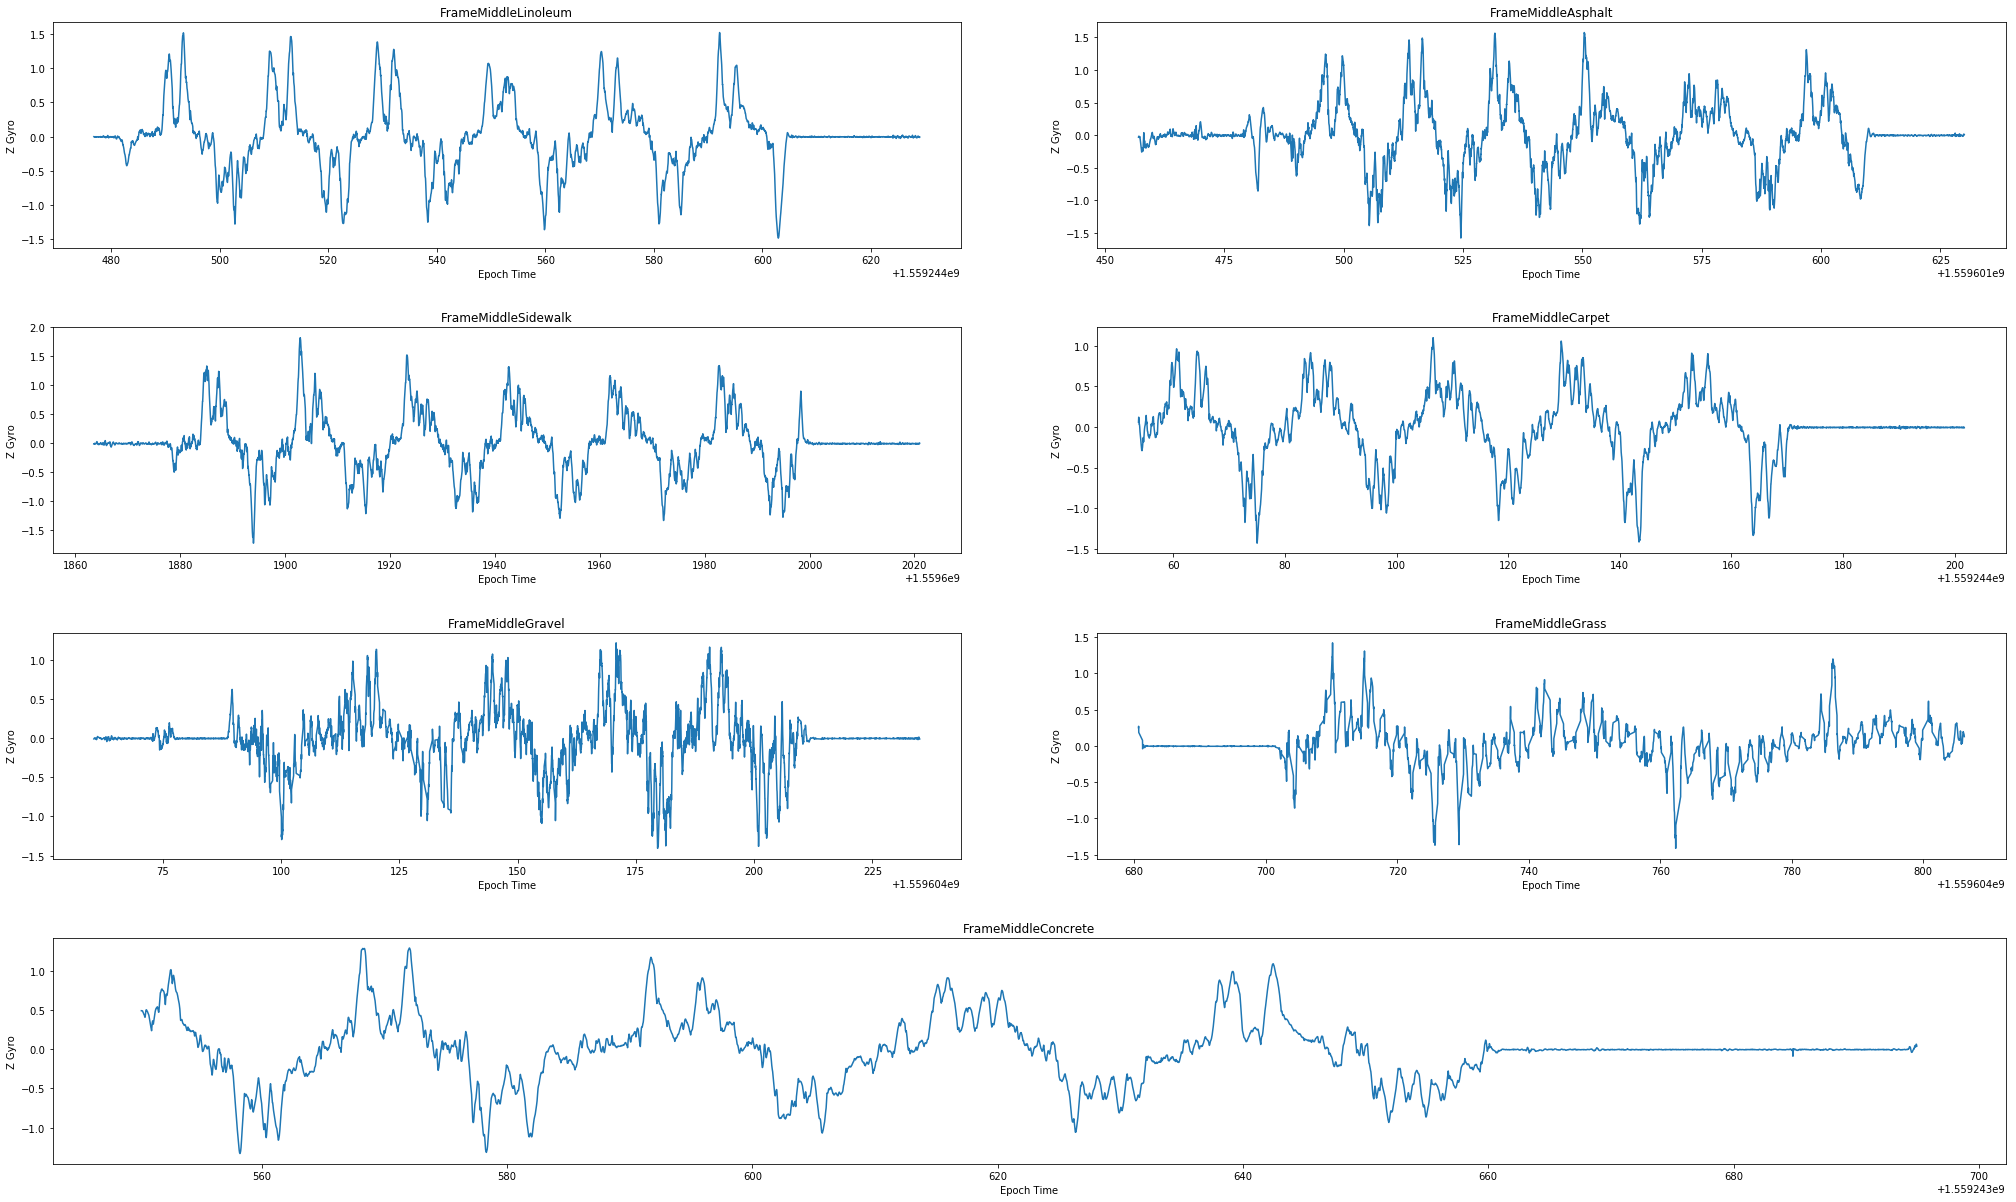

In [25]:
# Plot all filtered datasets
datasets_to_plot = {label: dataset for label, dataset in datasets.items() if ('Frame' in label)}
plot_all(np_to_pd(datasets_to_plot), x_axis='Epoch Time', y_axis='Z Gyro')

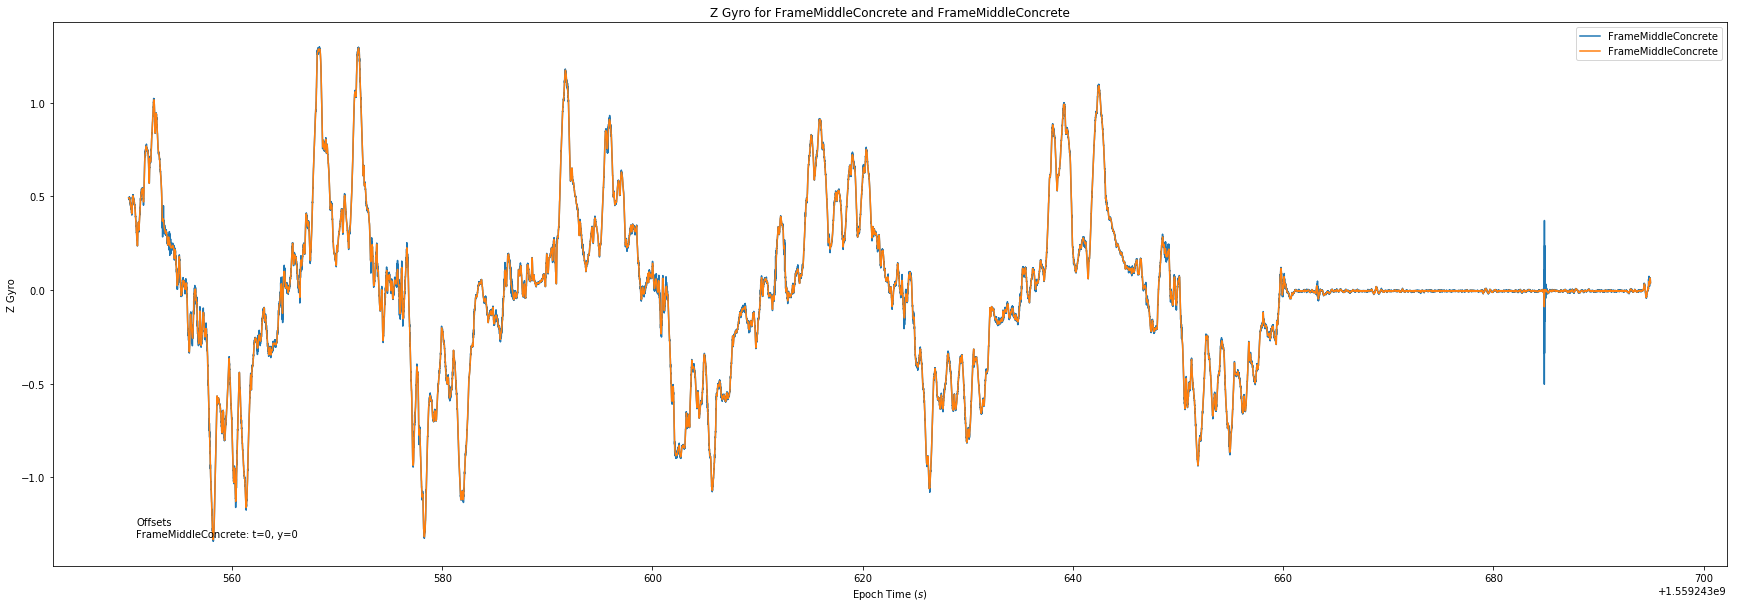

In [26]:
# Compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), 'FrameMiddleConcrete', 
                np_to_pd(datasets), 'FrameMiddleConcrete', 'Z Gyro')

## Part 3 - Time Windows

### Part (a) - Finding an optimal time window

Strategy is to start with a large time window and work down. 

Plot classification accuracy and time vs window size and find an optimal size

### Part (b) - Creating Time Windowed Data

In [27]:
# TODO: Create an array of different window sizes, taking out the desired array so don't have to rename things

WINDOW_SIZE = 200 # Divide by F_SAMP to get window size in seconds
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in raw_datasets.items():   
    n_windows = int(len(dataset) / WINDOW_SIZE)
    n_points = n_windows*WINDOW_SIZE
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [28]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 38
Num of windows in first dataset: 157
Shape of individual window: (200, 8)


Structure of windowed data:

`Terrain Dataset Dictionary -> Window List -> NP Array with Row = Datapoint, Col = Direction | Time`

In [29]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)['FrameMiddleConcrete'][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Epoch Time
195,-0.604234,-2.213861,0.002034,0.009057,0.073921,0.574984,1.559244e+09
196,-1.189363,-1.826960,0.033082,-0.024640,0.049680,0.569789,1.559244e+09
197,0.171956,-0.644762,-0.375314,-0.059803,0.044352,0.573785,1.559244e+09
198,-0.026271,0.043062,0.706576,0.026638,0.127730,0.635319,1.559244e+09
199,-1.067560,-0.637597,0.596716,0.103489,0.010256,0.655697,1.559244e+09


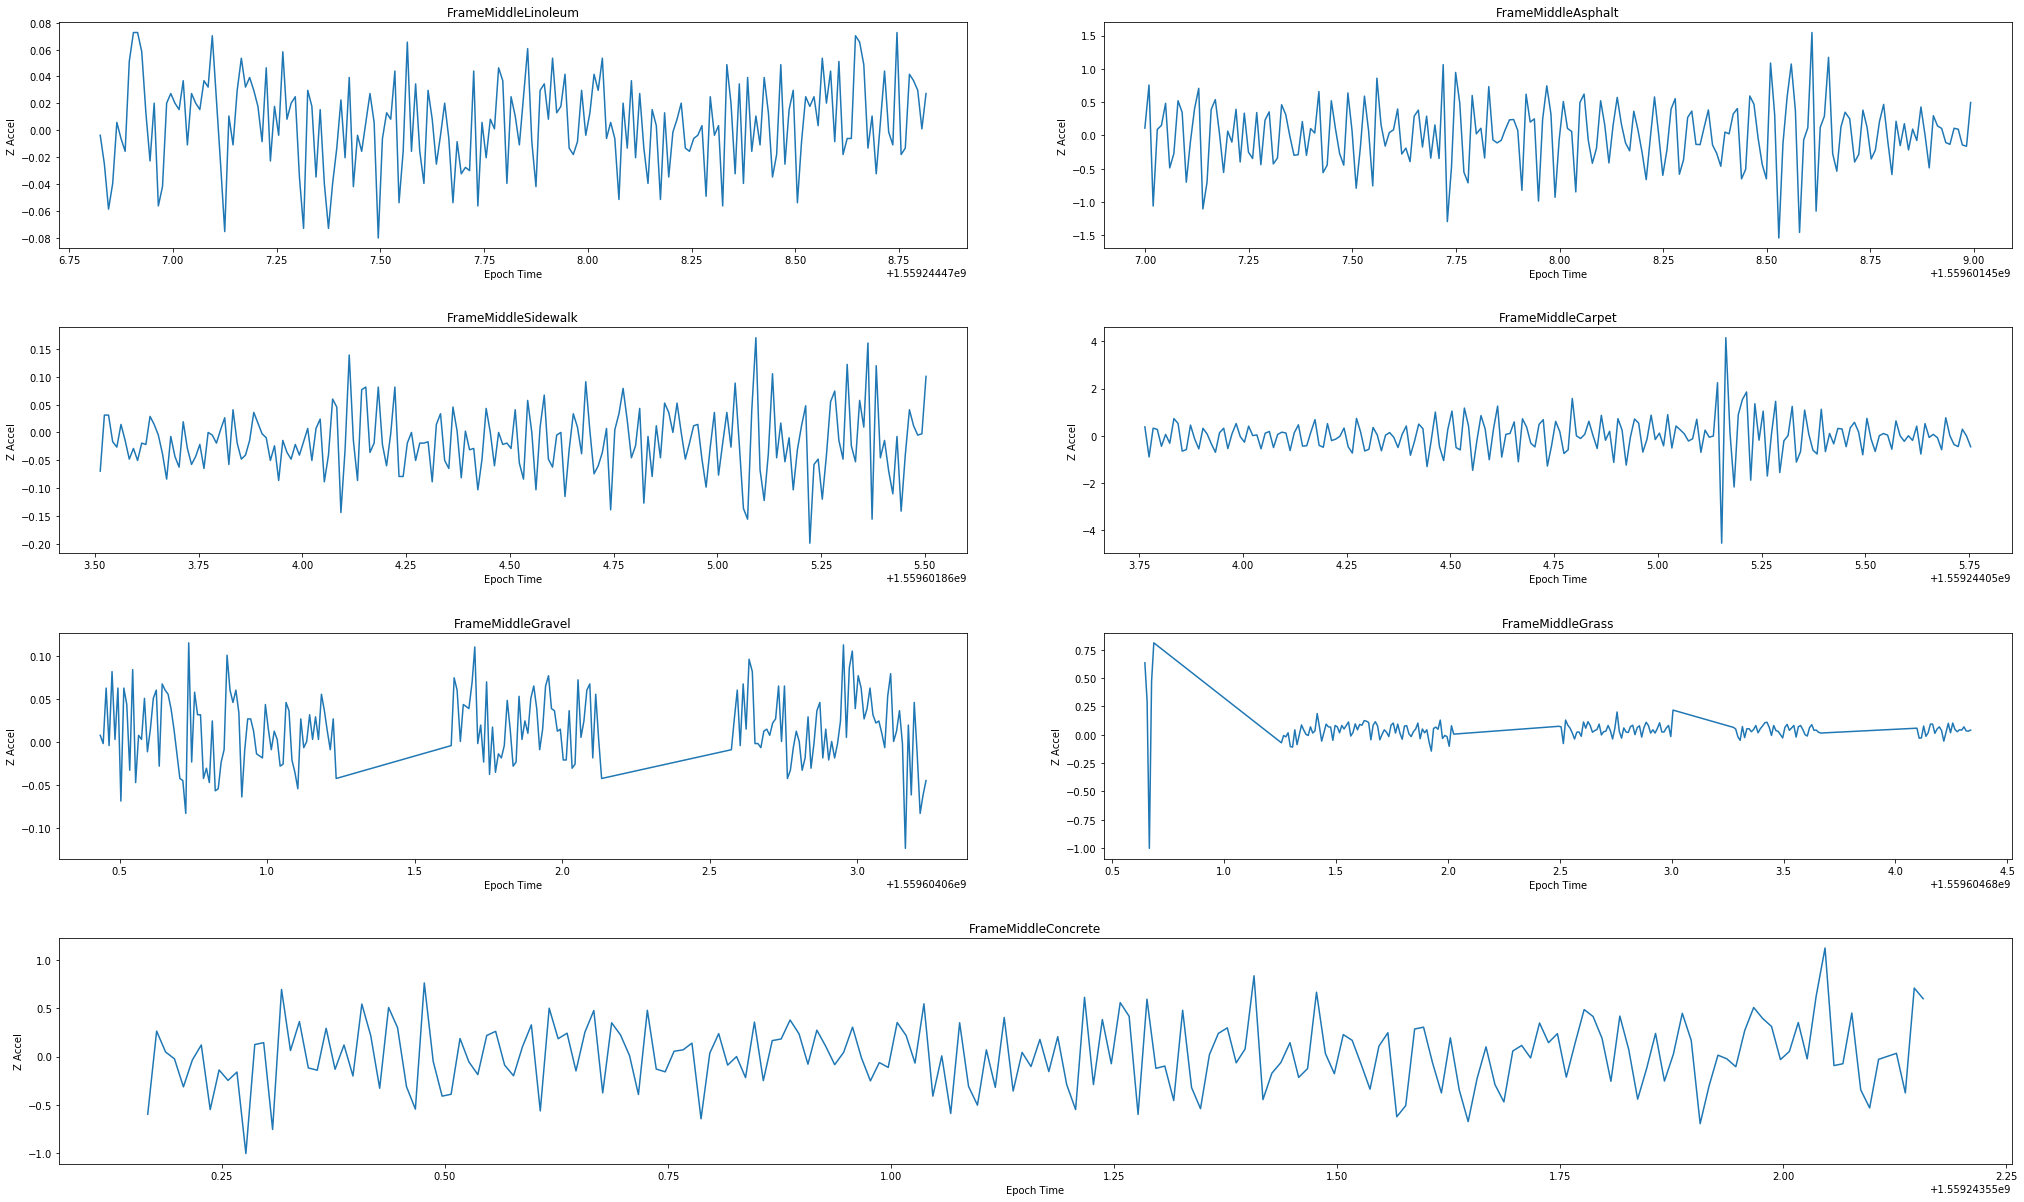

In [30]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if ('Frame' in label)}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Epoch Time', y_axis='Z Accel', windowed=True, win_num=0)

## Part 4 - FFT and PSD


In [31]:
'''Plot tranform of given direction and window'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 10))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + 
              ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
    plt.show()

### Part (a) - FFT
Its possible the FFT is not valid due to the non determinisitic update rate. Probably needs some interpolation.

In [32]:
datasets_fft = {}

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between datasets
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), WINDOW_SIZE)), n_bins)
            
        freq_col = np.transpose([np.linspace(0.0, f_samp / 2, n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [33]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[0]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[0]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)['FrameMiddleConcreteFFT'][0].head()

Num of FFT'd windowed datasets: 38
Num of FFT'd windows in first dataset: 157
Shape of FFT'd individual window: (100, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.681388,1.465374,0.016471,0.029052,0.046181,0.507189,0.000000
1,0.053862,0.047592,0.008269,0.010846,0.011022,0.086107,0.505051
2,0.038845,0.205059,0.017238,0.001713,0.003279,0.028052,1.010101
3,0.035676,0.024807,0.028875,0.000603,0.002023,0.033410,1.515152
4,0.028910,0.092321,0.022931,0.002066,0.001967,0.009857,2.020202


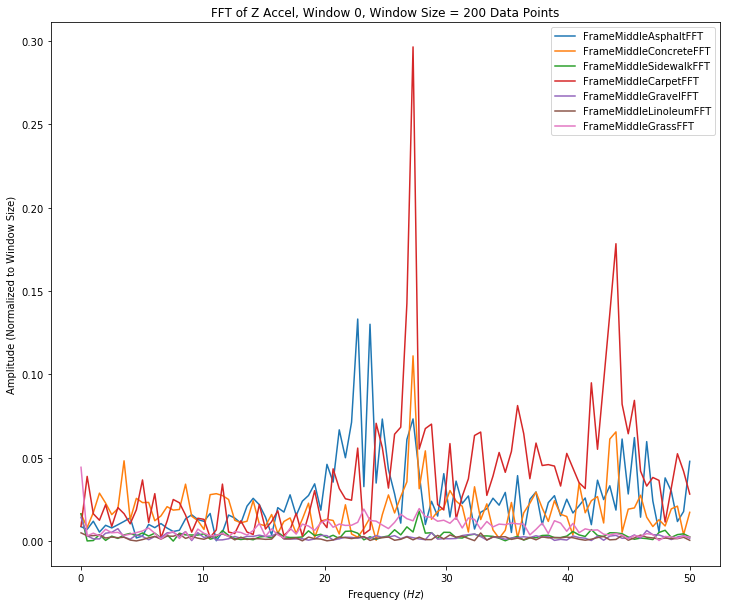

In [34]:
# Plot Z Accel of 0th window, Frame only
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Frame' in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

The Butterworth cutoff frequency is pretty noticeable. Theres not an easily recognizable cutoff from the unfiltered data.

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

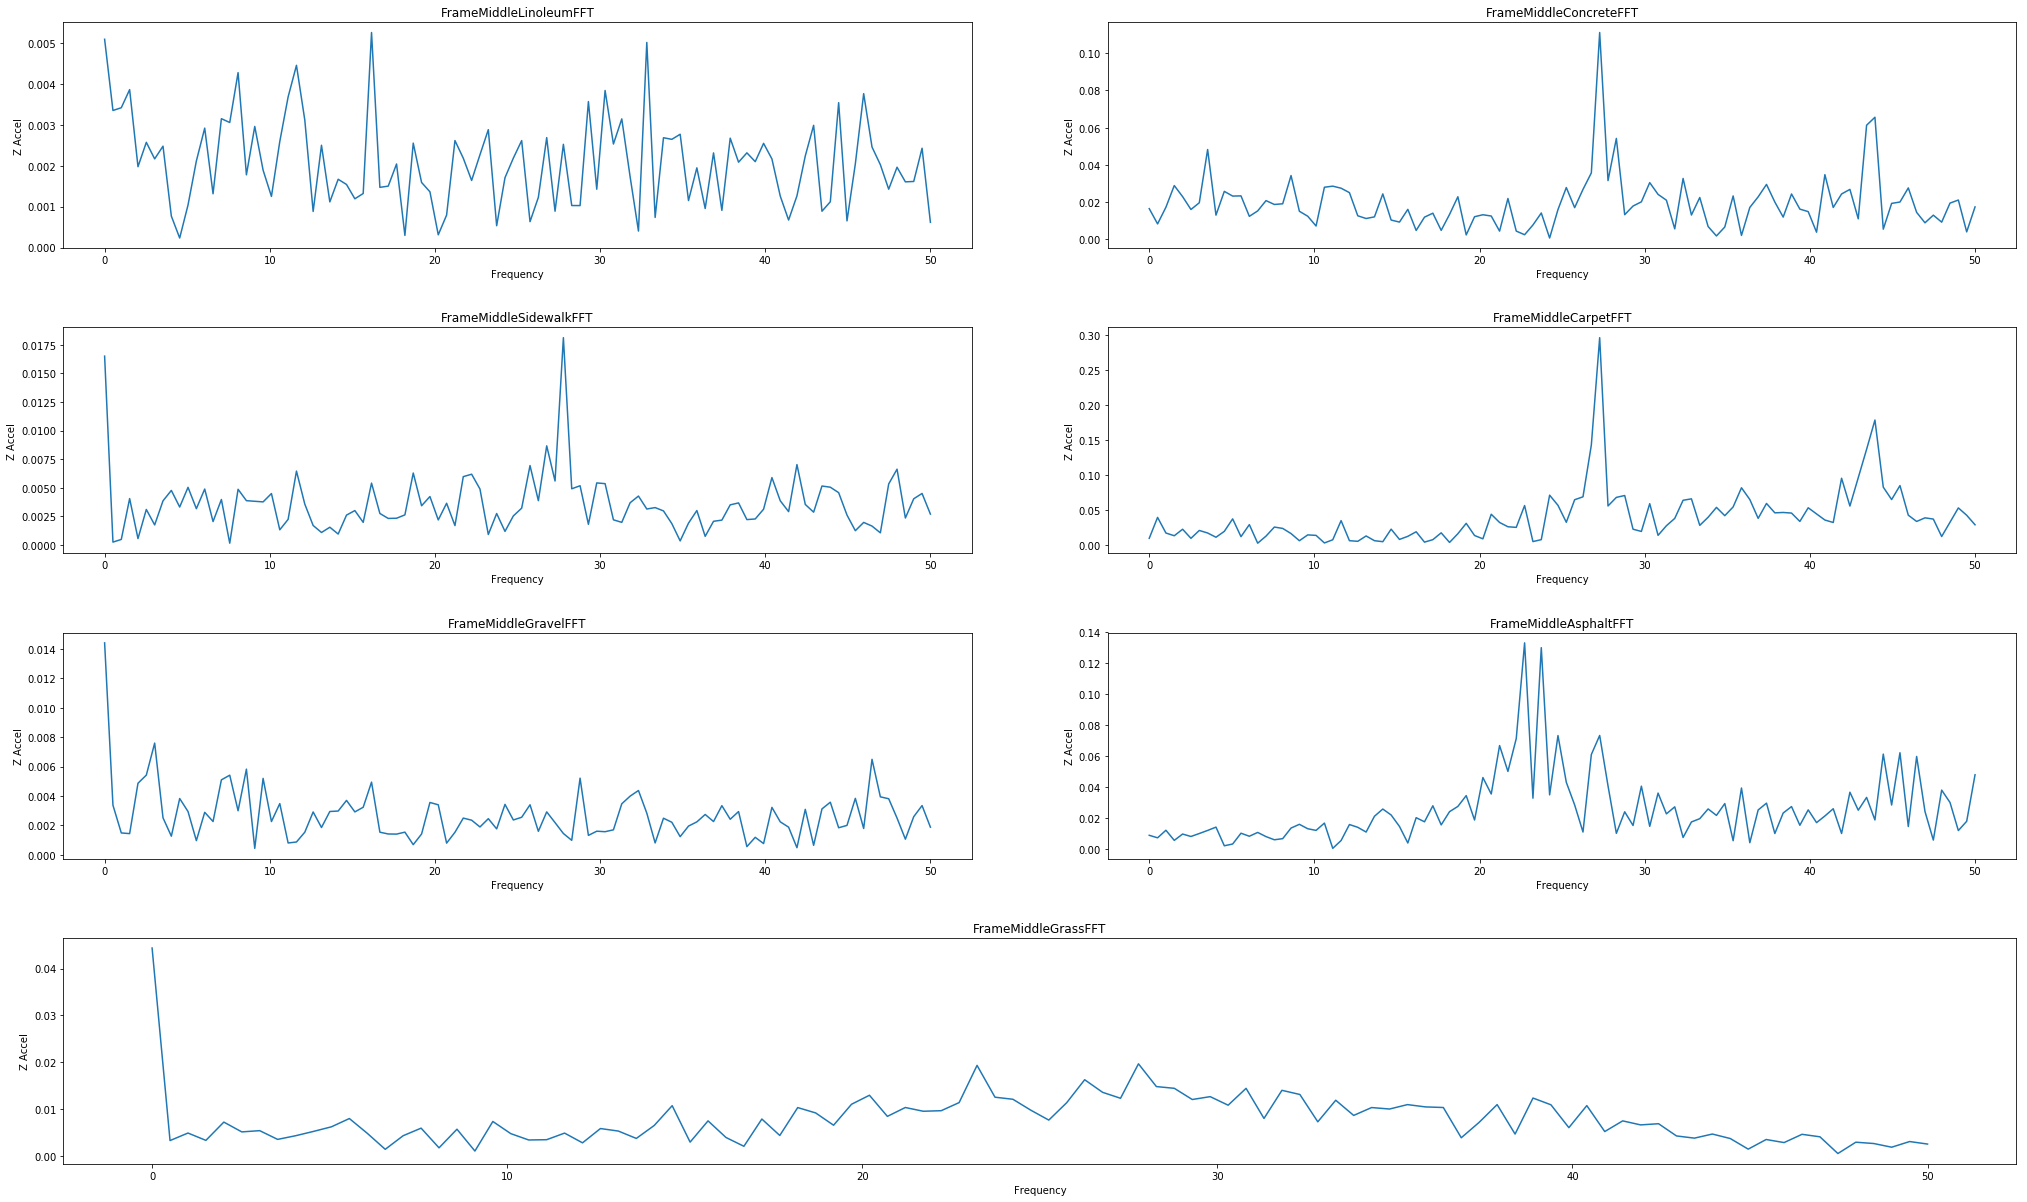

In [35]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [36]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Number of frequency bins is half of window size to trim the symmetric higher frequencies
        n_bins = int(WINDOW_SIZE / 2)
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        f_samp, f_low, f_high = get_frequencies(label)
        
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            window_psd_log[:, i] = np.log10(window_psd[:, i])
            
        # Append freq column
        freq_col = np.transpose([freq[:-1]])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


In [37]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd['FrameMiddleConcretePSD'][0].shape))

Num PSD'd windowed datasets: 38
Num of PSD'd windows in first dataset: 157
Shape of PSD'd individual window: (100, 7)


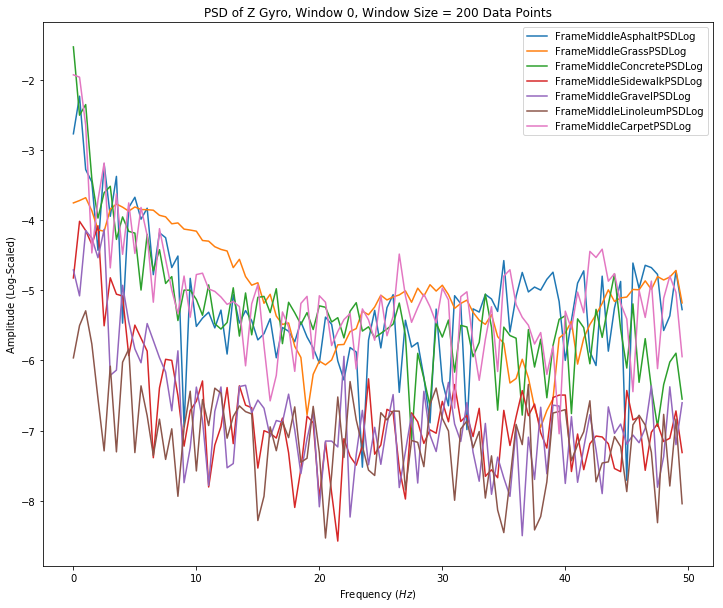

In [38]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'FrameMiddle' in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=5, transform_name='PSD')

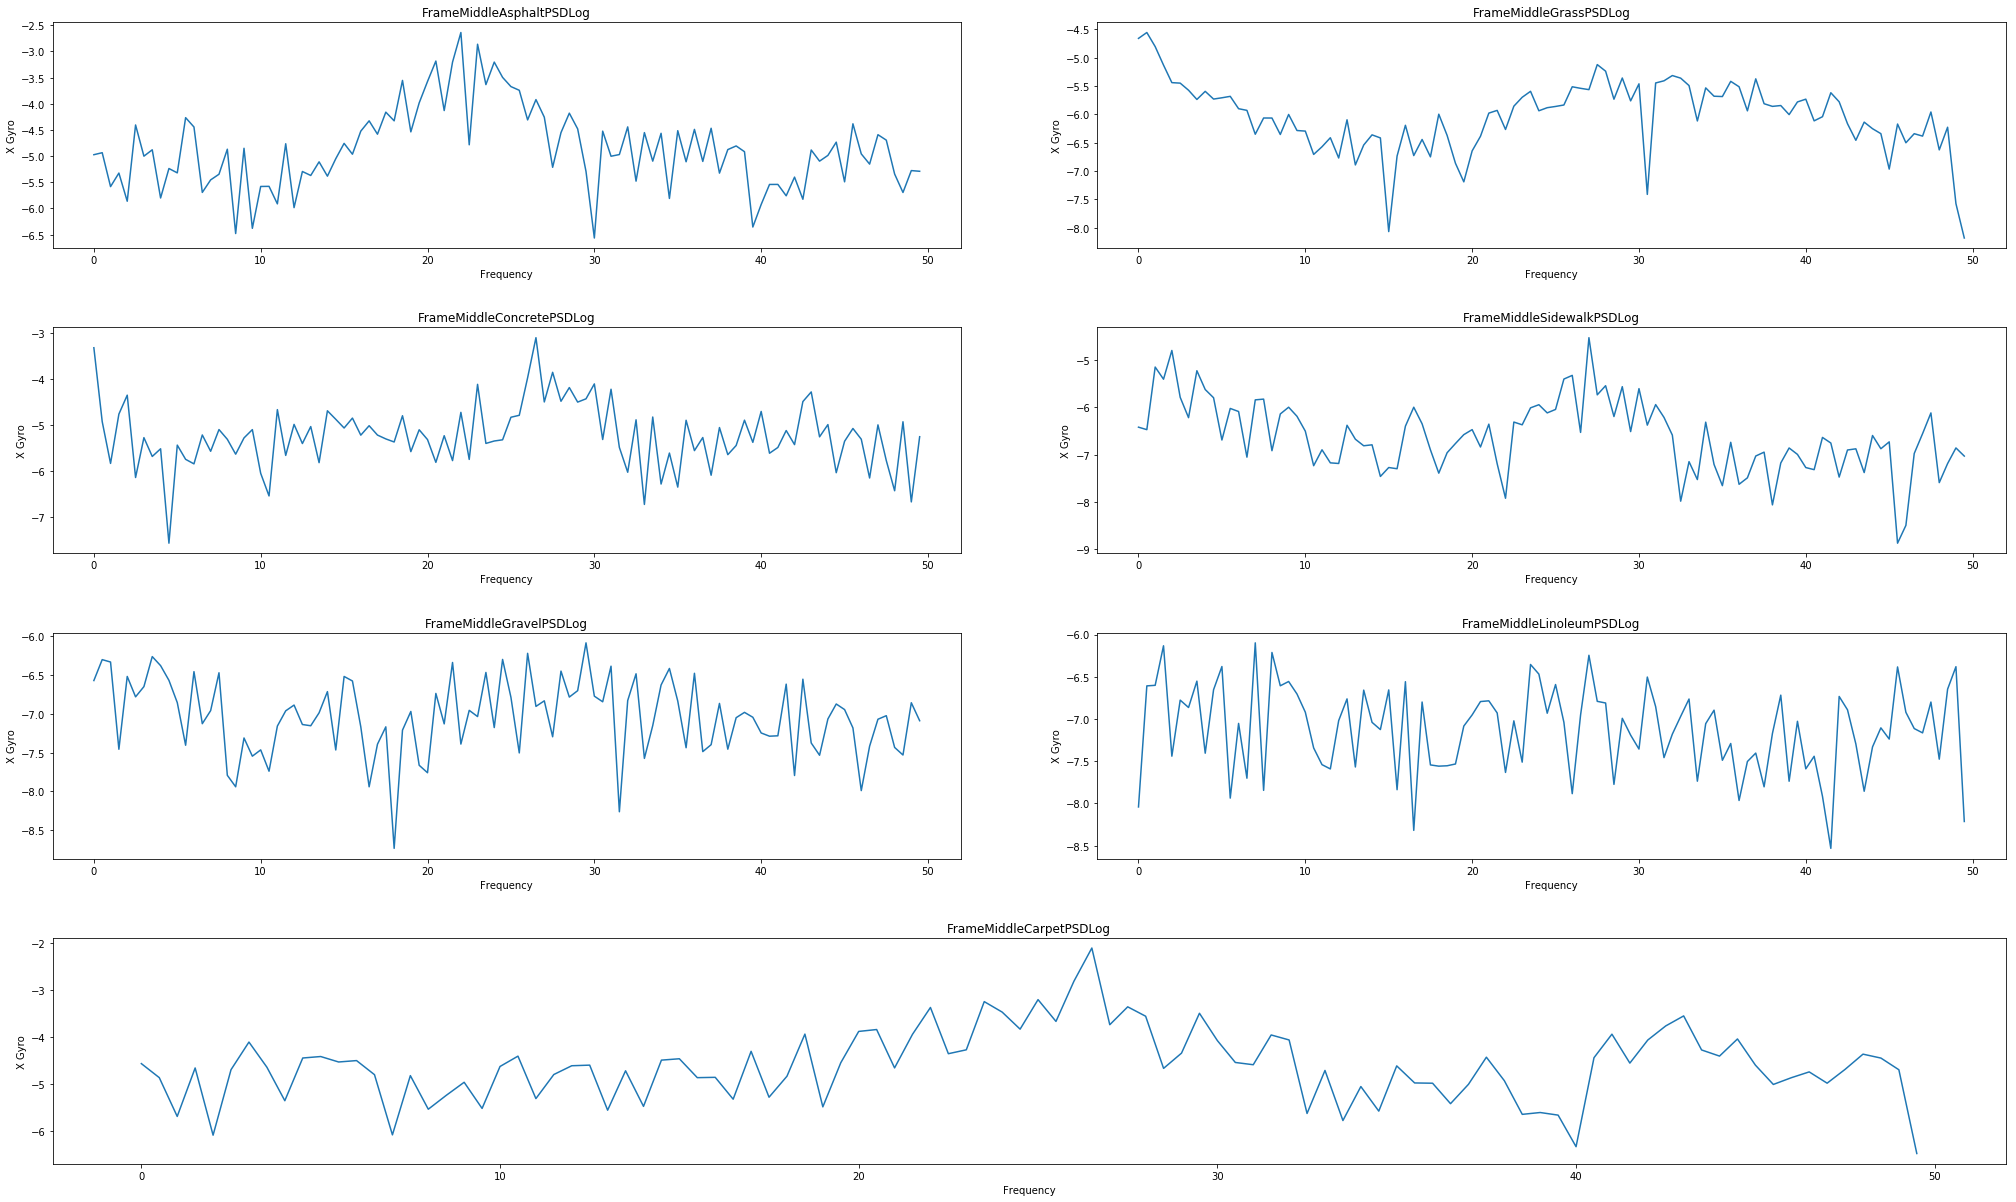

In [39]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Gyro', windowed=True)

Note that at this point, data is stored like:

`Labelled Terrain Dataset -> Time Window -> 2D NumPy Array Col = Dirn | Frequency)`

### Part (c) - 3D Visualization

In [40]:
'''Plot the set transforms in 3d'''
# TODO: Convert to bar graphs for better representation
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if (transform_name == 'FFT'):
        ax.set_zlim(0, 0.8)
        ax.set_zlabel('Amplitude (Normalized)')
    elif (transform_name == 'PSD'):
        ax.set_zlim(-20, 10)
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    # Change y axis to correspond with whats being plotted
    n_datasets = len(datasets_transformed)
    ax.set_ylim(0, n_datasets)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1))
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + 
                 ', Window {}, Window Size = {} Data Points'.format(win_num, WINDOW_SIZE))
        
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        ax.plot(xs=dataset[win_num][:, -1], ys=dataset[win_num][:, dirn],
                zs=i+1, zdir='y', label=label)
    
    ax.legend()
    plt.show()

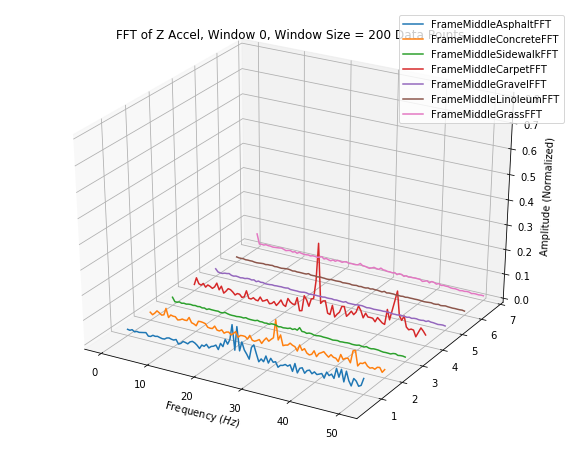

In [41]:
# Plot 3d Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Frame' in label}
plot_transforms_3d(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

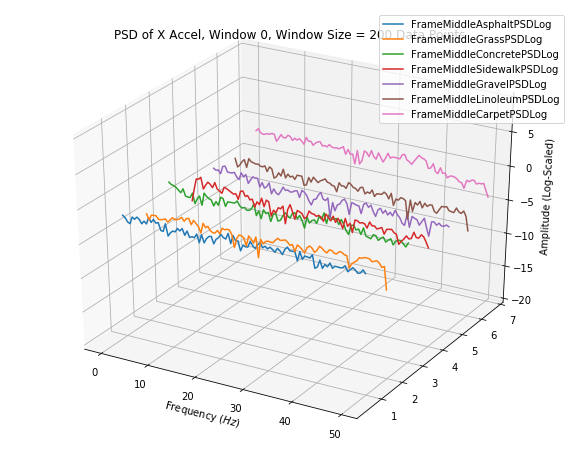

In [42]:
# Plot 3d Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Frame' in label}
plot_transforms_3d(psds_to_plot, win_num=0, dirn=0, transform_name='PSD')

### Part (d) - Spectograms

In [43]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size=WINDOW_SIZE):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 9))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

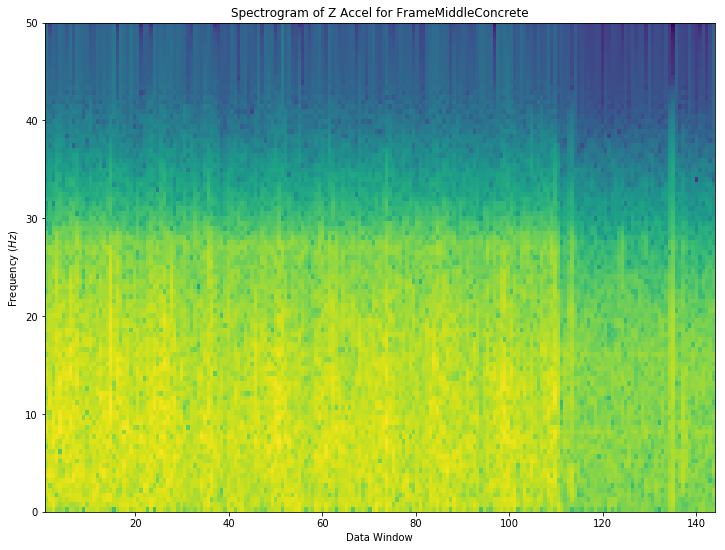

In [44]:
# X Accel
plot_spectogram('FrameMiddleConcrete', dirn=2, size=200)

## Part 5 - Feature Extraction

Structure of feature data:

`Terrain Dataset Dictionary -> Direction Dictionary -> Pandas Array with Row = Window #, Col = Feature`

In [45]:
# Feature extraction functions

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [46]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:N_DATA_COL]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [47]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name):
    plt.clf()
    plt.figure(figsize=(8,6))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(dirn + ', Window Size = {} Data Points'.format(WINDOW_SIZE))
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [48]:
# Time domain feature function names and actual names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 
N_TIME_FEATS = len(time_features)

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [49]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 38
Num directions: 6
Shape of first dataset first direction: (157, 10)


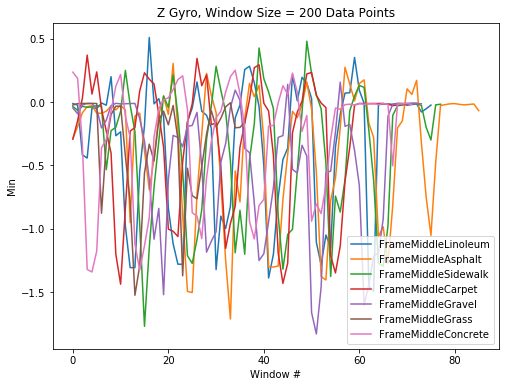

In [50]:
# Plot Max of Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Frame' in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Gyro', feat_name='Min')

### Part (b) - Frequency Domain Features

In [51]:
# Time domain feature function names and actual names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}
N_FREQ_FEATS = len(freq_features)

# Calculate features for each window of each column of each dataset
# Create array of features of each window for each dataset and direction
# TODO: Check if psd is correct
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide


In [52]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 38
Num directions: 6
Shape of one direction: (157, 5)


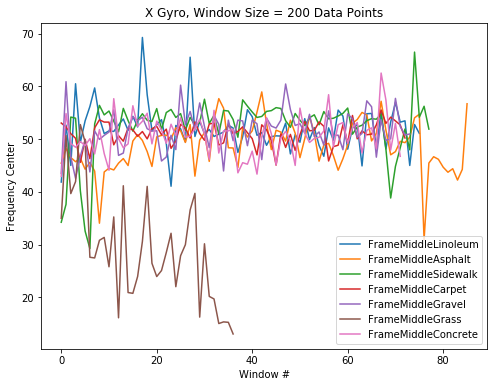

In [53]:
# Plot RVF of Z Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Frame' in label}
plot_set_features(feat_datasets_to_plot, dirn='X Gyro', feat_name='Frequency Center')

Lots of very similar shapes i.e. highly correlated variables in both time and frequency. Need to implement feature selection.

**Ideally we can implement feature selection over all directions, with FFT + PSD + Time Features + Freq Features**

## Part 5 - Feature Selection

In [137]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [138]:
'''Move frequency column to index'''
def set_freq_indices(datasets):
    for dataset in datasets.values():
        for window in dataset:
            window = window.set_index('Frequency')

In [139]:
# Apply frequency indexing to every dataset
set_freq_indices(datasets_fft)
set_freq_indices(datasets_psd_log)

In [140]:
# Confirm formatting
datasets_fft['FrameMiddleConcreteFFT'][0].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.681388,1.465374,0.016471,0.029052,0.046181,0.507189,0.000000
1,0.053862,0.047592,0.008269,0.010846,0.011022,0.086107,0.505051
2,0.038845,0.205059,0.017238,0.001713,0.003279,0.028052,1.010101
3,0.035676,0.024807,0.028875,0.000603,0.002023,0.033410,1.515152
4,0.028910,0.092321,0.022931,0.002066,0.001967,0.009857,2.020202


In [141]:
# Add time and freq features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [142]:
# Confirm formatting
datasets_feat['FrameMiddleAsphalt']['X Gyro'].head()

,Autocorrelation,Excess Kurtosis,L2 Norm,Max,Mean,Min,Root Mean Squared,Skew,Std Dev,Zero Crossing Rate,Frequency Center,Mean Square Frequency,Root Mean Square Frequency,Root Variance Frequency,Variance Frequency
0,1.335518,0.068921,1.155646,0.257058,0.048156,-0.134123,0.081717,0.199678,0.066020,0.370,45.441655,0.045303,0.212846,0.212846,-2064.898710
1,0.681083,-0.512822,0.825278,0.146243,0.042296,-0.059403,0.058356,0.035502,0.040205,0.245,48.230094,0.016603,0.128854,0.128854,-2326.125332
2,0.563821,-0.259170,0.750880,0.115210,0.042315,-0.055407,0.053095,-0.021738,0.032071,0.160,46.512941,0.009099,0.095386,0.095386,-2163.444571
3,0.679503,2.243014,0.824320,0.189530,0.038040,-0.171416,0.058288,-0.292832,0.044164,0.260,45.719571,0.014475,0.120311,0.120311,-2090.264719
4,0.494423,-0.438894,0.703152,0.124400,0.038676,-0.044619,0.049720,-0.067585,0.031246,0.230,46.392224,0.007317,0.085540,0.085540,-2152.231148


### Part (a) - Standardization

Standardize each feature to mean 0 and standard deviation 1. This will make PCA and classification easier.

In [143]:
'''Normalize already featured datasets'''
# TODO: Make this return a new dataset insetead
def normalize_datasets(datasets, windowed=False):
    datasets_norm = {}
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(pre.scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(pre.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [146]:
# So we can remove infinites
pd.set_option('use_inf_as_null', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

/home/caris/anaconda2/envs/python3.4/lib/python3.4/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


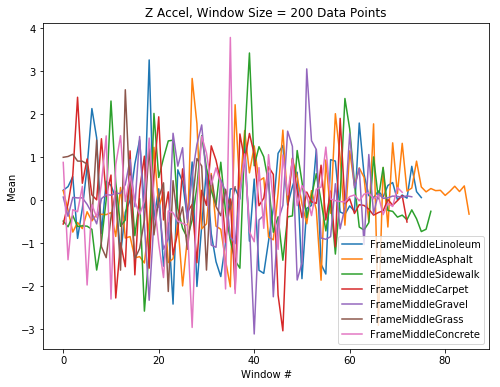

In [147]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Frame' in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='Mean')

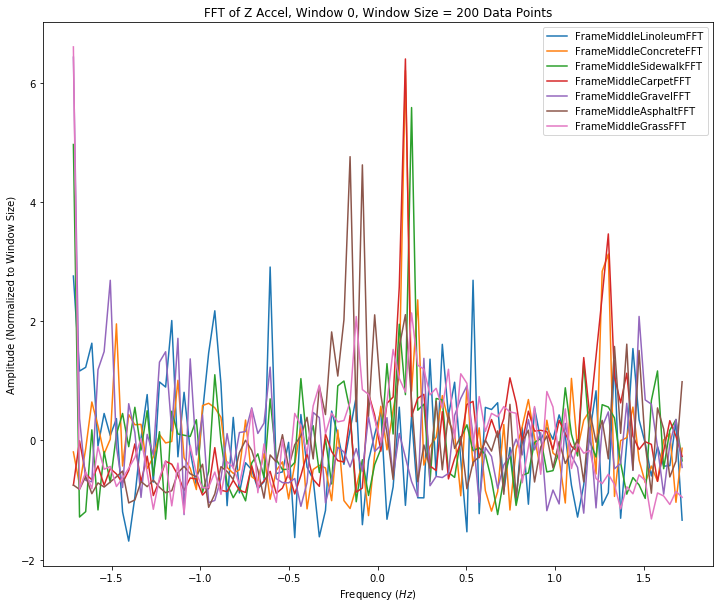

In [148]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Frame' in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=2, win_num=0, transform_name='FFT')

### Part (b) - Combining into Single Dataframe

In [149]:
'''Combined directions of a featured dataset'''
def combine_dirns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            dirn_df.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [150]:
# Take frame data and combine directions
datasets_feat_combined = combine_dirns(datasets_feat_norm)

datasets_feat_combined['FrameMiddleConcrete'].head()

,Autocorrelation Z Gyro,Excess Kurtosis Z Gyro,L2 Norm Z Gyro,Max Z Gyro,Mean Z Gyro,Min Z Gyro,Root Mean Squared Z Gyro,Skew Z Gyro,Std Dev Z Gyro,Zero Crossing Rate Z Gyro,...,Min Z Accel,Root Mean Squared Z Accel,Skew Z Accel,Std Dev Z Accel,Zero Crossing Rate Z Accel,Frequency Center Z Accel,Mean Square Frequency Z Accel,Root Mean Square Frequency Z Accel,Root Variance Frequency Z Accel,Variance Frequency Z Accel
0,0.502626,-0.177294,0.744218,1.144970,1.387232,1.151865,0.744218,0.481046,-0.070014,-0.764309,...,0.393666,-0.259281,-0.020968,-0.259053,0.480409,-0.723523,-0.369038,-0.123752,-0.123752,0.736175
1,1.223396,-0.336158,1.195580,1.678364,1.605062,1.042302,1.195580,-0.021966,1.026384,-0.764309,...,-3.433693,2.398020,2.551718,2.398254,-0.910587,1.695722,2.439306,1.989157,1.989157,-1.769359
2,-0.785485,-0.144003,-0.639433,-0.009454,0.138965,-0.107964,-0.639433,-0.872930,0.050807,0.410393,...,-0.201918,0.630149,-0.108288,0.631731,0.758608,0.402080,0.224469,0.515026,0.515026,-0.340933
3,0.277756,0.114888,0.580518,-0.503834,-0.867674,-2.276316,0.580518,-2.077542,1.649923,0.139308,...,-1.891033,2.242275,-1.097337,2.243725,0.944074,1.061489,2.686749,2.116894,2.116894,-1.040773
4,2.092182,0.072157,1.647013,-1.336533,-1.884535,-2.320963,1.647013,-1.566778,0.721556,-0.764309,...,0.508877,-0.012868,0.813996,-0.011332,0.851341,0.118927,-0.095538,0.200395,0.200395,-0.055556


### Part (c) - Adding Labels

In [173]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        labels = [get_terrain_num(label) for _ in range(len(dataset))]
        dataset.insert(0, 'Label', labels)

In [ ]:
# Add labels
insert_labels(datasets_feat_combined)
#insert_labels(datasets_fft, windowed=True)
#insert_labels(datasets_psd_log, windowed=True)

#TODO: Export these as .csv

In [154]:
# Check labelled transform data
datasets_fft['FrameMiddleAsphaltFFT'][0].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.620391,1.475190,0.008794,0.048156,0.017759,0.134770,0.000000
1,0.025183,0.113333,0.007167,0.001632,0.002242,0.020669,0.505051
2,0.018076,0.061432,0.012060,0.001706,0.005397,0.038333,1.010101
3,0.009880,0.012453,0.005516,0.000809,0.000181,0.011496,1.515152
4,0.008016,0.017280,0.009609,0.001090,0.002201,0.009370,2.020202


In [156]:
# Check labelled feature data
datasets_feat_combined['FrameMiddleAsphalt'].head()

,Label,Autocorrelation Z Gyro,Excess Kurtosis Z Gyro,L2 Norm Z Gyro,Max Z Gyro,Mean Z Gyro,Min Z Gyro,Root Mean Squared Z Gyro,Skew Z Gyro,Std Dev Z Gyro,...,Min Z Accel,Root Mean Squared Z Accel,Skew Z Accel,Std Dev Z Accel,Zero Crossing Rate Z Accel,Frequency Center Z Accel,Mean Square Frequency Z Accel,Root Mean Square Frequency Z Accel,Root Variance Frequency Z Accel,Variance Frequency Z Accel
0,3,-0.742453,-0.347327,-0.726014,-0.641869,-0.318600,0.132201,-0.726014,0.511025,-0.817679,...,1.028615,-1.090894,-0.612902,-1.090222,-1.113897,-1.057690,-0.996588,-1.021741,-1.021741,1.091377
1,3,-0.795260,-0.486697,-0.921713,-0.581602,-0.171835,0.319333,-0.921713,-0.297545,-0.916917,...,1.215611,-1.206707,0.690563,-1.206064,-0.378040,-0.673840,-1.061376,-1.250956,-1.250956,0.732621
2,3,-0.825445,0.276342,-1.155095,-0.664209,-0.035428,0.540123,-1.155095,-0.980310,-1.256394,...,1.296728,-1.288236,0.754569,-1.289112,-0.511832,-0.430830,-1.068662,-1.287361,-1.287361,0.495428
3,3,-0.820561,0.083385,-1.089455,-0.492242,0.066023,0.638132,-1.089455,0.788367,-1.164185,...,1.165233,-1.217639,1.301406,-1.217548,-0.444936,-0.604689,-1.055147,-1.222670,-1.222670,0.666064
4,3,-0.826264,-0.275438,-1.172409,-0.606280,0.006382,0.652941,-1.172409,0.933176,-1.273696,...,1.317220,-1.348630,-0.224069,-1.349412,-1.113897,-0.880807,-1.078364,-1.344023,-1.344023,0.927906


In [160]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [179]:
# Combine all frame data
datasets_frame = {label: dataset for label, dataset in datasets_feat_combined.items() if 'Frame' in label}
frame_feats_all = combine_datasets(datasets_frame)

# Export to csv
frame_feats_all.to_csv('featured_data/FrameFeaturesAll.csv', index=False)

# Check that terrains are valid, converting back to terrain names
frame_feats_all.head()

,Label,Autocorrelation Z Gyro,Excess Kurtosis Z Gyro,L2 Norm Z Gyro,Max Z Gyro,Mean Z Gyro,Min Z Gyro,Root Mean Squared Z Gyro,Skew Z Gyro,Std Dev Z Gyro,...,Min Z Accel,Root Mean Squared Z Accel,Skew Z Accel,Std Dev Z Accel,Zero Crossing Rate Z Accel,Frequency Center Z Accel,Mean Square Frequency Z Accel,Root Mean Square Frequency Z Accel,Root Variance Frequency Z Accel,Variance Frequency Z Accel
0,2,-0.893059,0.275467,-1.206064,-0.613076,-0.022339,0.611106,-1.206064,0.373548,-1.237308,...,0.963540,-1.329478,-0.632443,-1.328938,-0.250367,-1.264782,-0.561999,-1.138378,-1.138378,1.184007
1,2,-0.892837,0.799393,-1.192434,-0.592634,-0.026213,0.588673,-1.192434,0.914549,-1.209830,...,0.894646,-1.233282,-0.220333,-1.232674,-0.481009,0.147298,-0.557675,-1.036782,-1.036782,-0.076673
2,2,-0.804398,0.552359,-0.724245,-0.613334,-0.254478,-0.155379,-0.724245,-1.729380,-0.485669,...,0.617879,-0.743436,-0.067827,-0.742728,-2.441460,-2.479740,-0.544905,-0.905645,-0.905645,2.042669
3,2,-0.720984,-0.412943,-0.528735,-0.681388,-0.425968,-0.200748,-0.528735,-1.148643,-0.429640,...,-0.839599,0.355428,-1.291512,0.355989,-0.711650,2.124071,0.153590,0.565511,0.565511,-2.312565
4,2,-0.880830,0.015920,-1.036550,-0.409691,0.091473,0.544816,-1.036550,-0.487458,-1.021290,...,0.468211,-0.338156,0.273366,-0.336690,-0.711650,-0.603006,-0.460554,-0.520471,-0.520471,0.628867


### Part (d) - mRMR

Necessary because of the number of different features/transforms in each direction.

Try to find which features are most relevant, from all directions.

In [181]:
# TODO: Compare different libraries
pymrmr.mRMR(data=frame_feats_all, method='MIQ', nfeats=20)

['Zero Crossing Rate Y Accel',
 'Zero Crossing Rate Z Gyro',
 'Skew X Gyro',
 'Mean Square Frequency X Accel',
 'Excess Kurtosis Z Gyro',
 'Mean Square Frequency Y Accel',
 'Frequency Center X Gyro',
 'Frequency Center Z Gyro',
 'Variance Frequency X Accel',
 'Skew Y Accel',
 'Skew X Accel',
 'Frequency Center Y Accel',
 'Mean Square Frequency Z Accel',
 'Skew Z Accel',
 'Zero Crossing Rate Y Gyro',
 'Mean Square Frequency Z Gyro',
 'Mean Square Frequency Y Gyro',
 'Skew Y Gyro',
 'Skew Z Gyro',
 'Zero Crossing Rate X Accel']

In [182]:
# TODO: Compare different libraries
pymrmr.mRMR(data=frame_feats_all, method='MID', nfeats=20)

['Zero Crossing Rate Y Accel',
 'Skew X Gyro',
 'Mean Square Frequency X Accel',
 'Frequency Center Z Gyro',
 'Mean Square Frequency Y Accel',
 'Excess Kurtosis Z Gyro',
 'Frequency Center Y Accel',
 'Skew X Accel',
 'Variance Frequency X Accel',
 'Zero Crossing Rate Z Gyro',
 'Mean Square Frequency Z Accel',
 'Skew Z Accel',
 'Frequency Center X Gyro',
 'Skew Y Accel',
 'Zero Crossing Rate Y Gyro',
 'Mean Square Frequency Y Gyro',
 'Skew Y Gyro',
 'Mean Square Frequency Z Gyro',
 'Skew Z Gyro',
 'Zero Crossing Rate X Accel']

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction` - Linear acceleration or gyroscope in $x,y$ or $z$